In [1]:
import pandas as pd
import numpy as np
import datetime as dt

df_clean = pd.read_csv('../data/processed/data_clean_uk.csv')

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349199 entries, 0 to 349198
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   349199 non-null  int64         
 1   InvoiceNo    349199 non-null  int64         
 2   InvoiceDate  349199 non-null  datetime64[ns]
 3   TotalPrice   349199 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 10.7 MB


In [2]:
last_order_date = df_clean['InvoiceDate'].max()
print(f"Data da última transação: {last_order_date.strftime('%Y-%m-%d')}")

snapshot_date = last_order_date + dt.timedelta(days=1)
print(f"Data de referência (Snapshot Date): {snapshot_date.strftime('%Y-%m-%d')}")

print(f"Dataset cobre o período de {df_clean['InvoiceDate'].min().strftime('%Y-%m-%d')} até {last_order_date.strftime('%Y-%m-%d')}")

Data da última transação: 2011-12-09
Data de referência (Snapshot Date): 2011-12-10
Dataset cobre o período de 2010-12-01 até 2011-12-09


In [3]:
rfm_table = df_clean.groupby('CustomerID').agg(
    LastPurchaseDate = ('InvoiceDate', 'max'),
    Frequency = ('InvoiceNo', 'nunique'),
    Monetary = ('TotalPrice', 'sum')
).reset_index()

rfm_table.head()

,CustomerID,LastPurchaseDate,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,11,4196.01
2,12748,2011-12-09 12:20:00,209,33053.19
3,12749,2011-12-06 09:56:00,5,4090.88
4,12820,2011-12-06 15:12:00,4,942.34


In [4]:
rfm_table['Recency'] = (snapshot_date - rfm_table['LastPurchaseDate']).dt.days

rfm_table.drop('LastPurchaseDate', axis=1, inplace=True)

rfm_table = rfm_table[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

print("Tabela RFM criada com sucesso:")
rfm_table.head()

Tabela RFM criada com sucesso:


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,2,11,4196.01
2,12748,1,209,33053.19
3,12749,4,5,4090.88
4,12820,3,4,942.34


In [5]:
rfm_stats = rfm_table.describe()
print(rfm_stats)

         CustomerID      Recency    Frequency       Monetary
count   3920.000000  3920.000000  3920.000000    3920.000000
mean   15562.059694    92.208418     4.246429    1858.424653
std     1576.594671    99.533854     7.199202    7478.631256
min    12346.000000     1.000000     1.000000       3.750000
25%    14208.750000    18.000000     1.000000     298.185000
50%    15569.500000    51.000000     2.000000     644.975000
75%    16913.250000   143.000000     5.000000    1571.285000
max    18287.000000   374.000000   209.000000  259657.300000


In [6]:
rfm_table.to_csv('../data/processed/rfm_table_final.csv', index=False)

print("Tabela RFM salva em 'data/processed/rfm_table_final.csv'")

Fase 2 Concluída. Tabela RFM salva em 'data/processed/rfm_table_final.csv'


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
rfm_table = pd.read_csv('../data/processed/rfm_table_final.csv')

rfm_data = rfm_table[['Recency', 'Frequency', 'Monetary']]
customer_ids = rfm_table['CustomerID']

rfm_data.head()

,Recency,Frequency,Monetary
0,326,1,77183.60
1,2,11,4196.01
2,1,209,33053.19
3,4,5,4090.88
4,3,4,942.34


<function matplotlib.pyplot.show(close=None, block=None)>

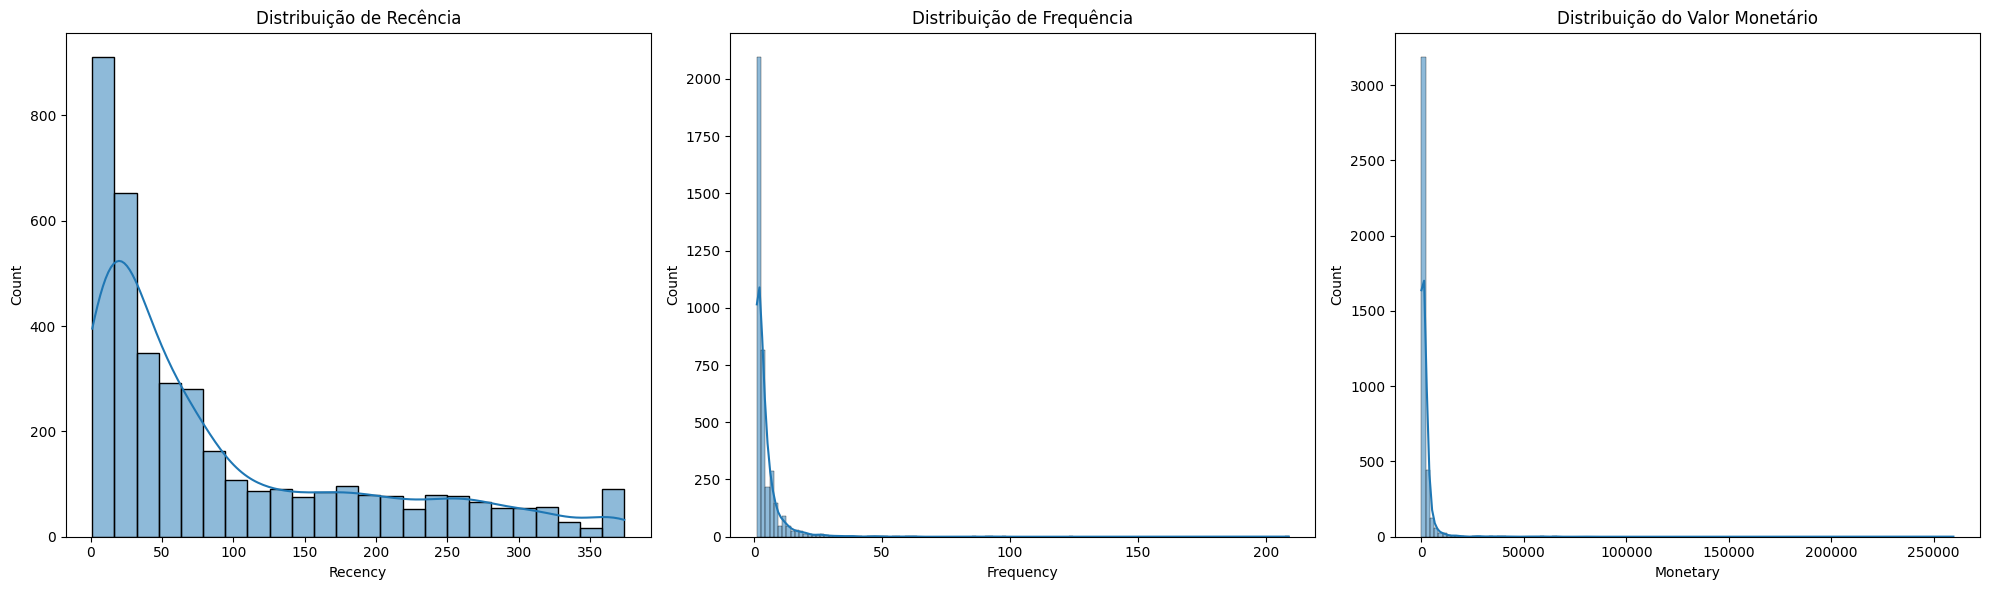

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.histplot(rfm_data['Recency'], kde=True, ax=axes[0])
axes[0].set_title('Distribuição de Recência')

sns.histplot(rfm_data['Frequency'], kde=True, ax=axes[1])
axes[1].set_title('Distribuição de Frequência')

sns.histplot(rfm_data['Monetary'], kde=True, ax=axes[2])
axes[2].set_title('Distribuição do Valor Monetário')

plt.tight_layout()
plt.show

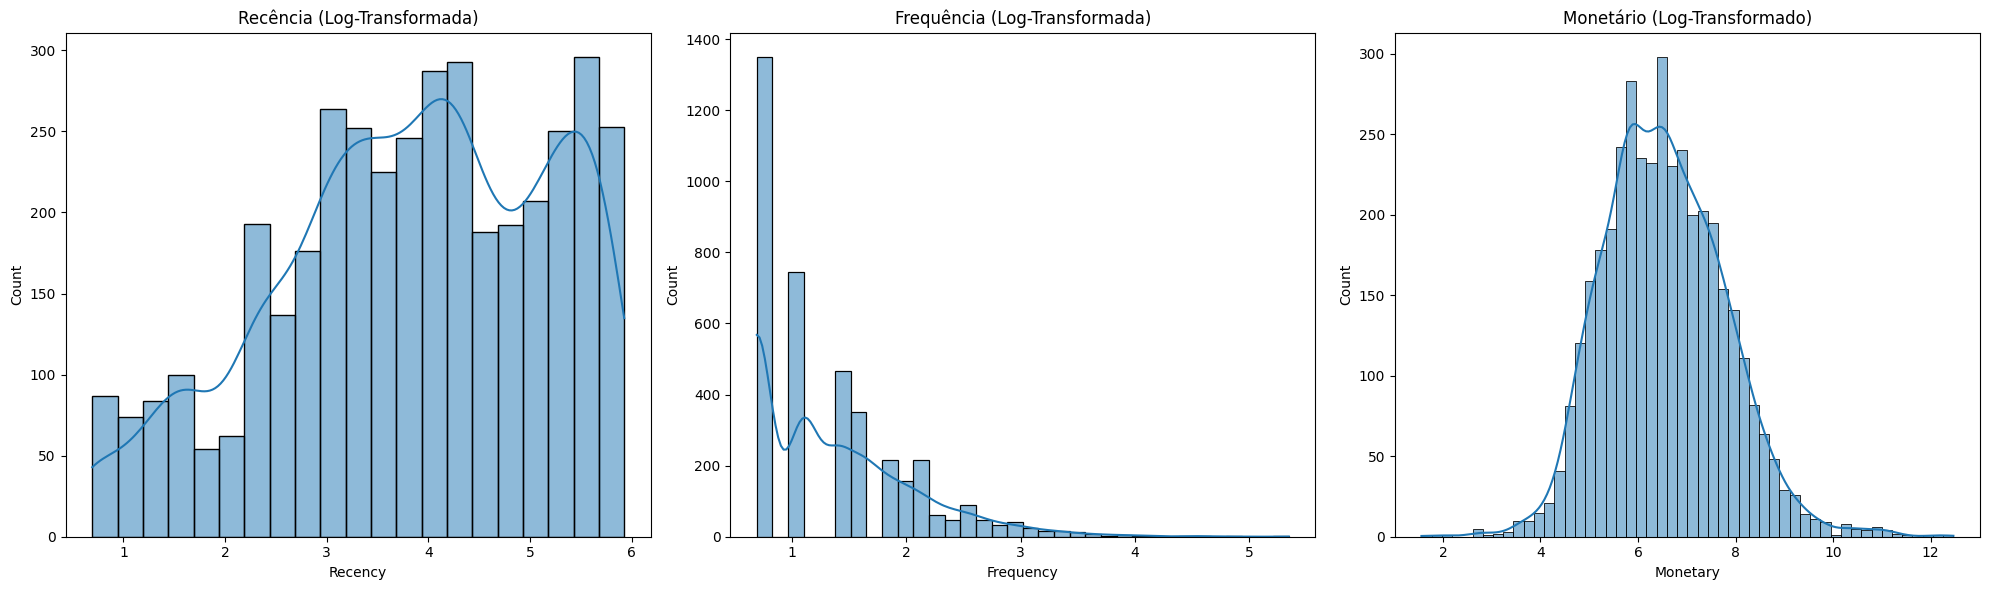

In [11]:
rfm_log = rfm_data.apply(np.log1p)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.histplot(rfm_log['Recency'], kde=True, ax=axes[0]).set_title('Recência (Log-Transformada)')
sns.histplot(rfm_log['Frequency'], kde=True, ax=axes[1]).set_title('Frequência (Log-Transformada)')
sns.histplot(rfm_log['Monetary'], kde=True, ax=axes[2]).set_title('Monetário (Log-Transformado)')
plt.tight_layout()
plt.show()

In [14]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled_df = pd.DataFrame(rfm_scaled, 
                             columns=rfm_data.columns, 
                             index=rfm_data.index)

print("Dados padronizados (média ~0, desvio padrão ~1):")
rfm_scaled_df.describe()

Dados padronizados (média ~0, desvio padrão ~1):


,Recency,Frequency,Monetary
count,3.920000e+03,3.920000e+03,3.920000e+03
mean,7.341067e-17,2.904706e-16,-6.634149e-16
std,1.000128e+00,1.000128e+00,1.000128e+00
min,-2.337994e+00,-9.574905e-01,-4.004447e+00
25%,-6.587334e-01,-9.574905e-01,-6.747839e-01
50%,9.225214e-02,-3.631397e-01,-5.617742e-02
75%,8.520132e-01,6.529098e-01,6.587338e-01
max,1.565933e+00,5.864515e+00,4.763099e+00


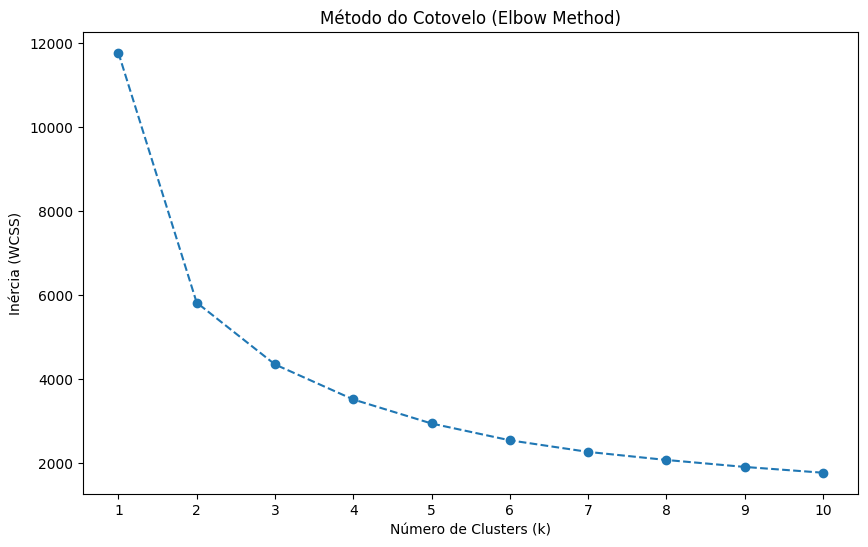

In [15]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, 
                    init='k-means++',
                    n_init=10,
                    random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.xticks(k_range)
plt.show()

In [16]:
K_IDEAL = 4

kmeans_final = KMeans(n_clusters=K_IDEAL, 
                      init='k-means++', 
                      n_init=10, 
                      random_state=42)

kmeans_final.fit(rfm_scaled_df)

cluster_labels = kmeans_final.labels_

In [17]:
rfm_table['Cluster'] = cluster_labels

rfm_table.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,326,1,77183.60,3
1,12747,2,11,4196.01,1
2,12748,1,209,33053.19,1
3,12749,4,5,4090.88,1
4,12820,3,4,942.34,2


In [18]:
cluster_summary = rfm_table.groupby('Cluster').agg(
    Recency_avg=('Recency', 'mean'),
    Frequency_avg=('Frequency', 'mean'),
    Monetary_avg=('Monetary', 'mean'),
    Count=('CustomerID', 'count')
).reset_index()

print("Resumo dos Clusters (Médias):")
cluster_summary.sort_values(by='Monetary_avg', ascending=False)

Resumo dos Clusters (Médias):


,Cluster,Recency_avg,Frequency_avg,Monetary_avg,Count
1,1,11.758942,13.558320,7157.118974,643
3,3,69.300377,4.165725,1710.862062,1062
2,2,19.532734,2.060334,512.835404,779
0,0,184.598189,1.322423,324.904492,1436


In [19]:
segment_map = {
    1: 'Campeões',
    3: 'Leais',
    2: 'Novos',
    0: 'Perdidos' 
}

rfm_table['Segmento'] = rfm_table['Cluster'].map(segment_map)

rfm_table.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segmento
0,12346,326,1,77183.60,3,Leais
1,12747,2,11,4196.01,1,Campeões
2,12748,1,209,33053.19,1,Campeões
3,12749,4,5,4090.88,1,Campeões
4,12820,3,4,942.34,2,Novos


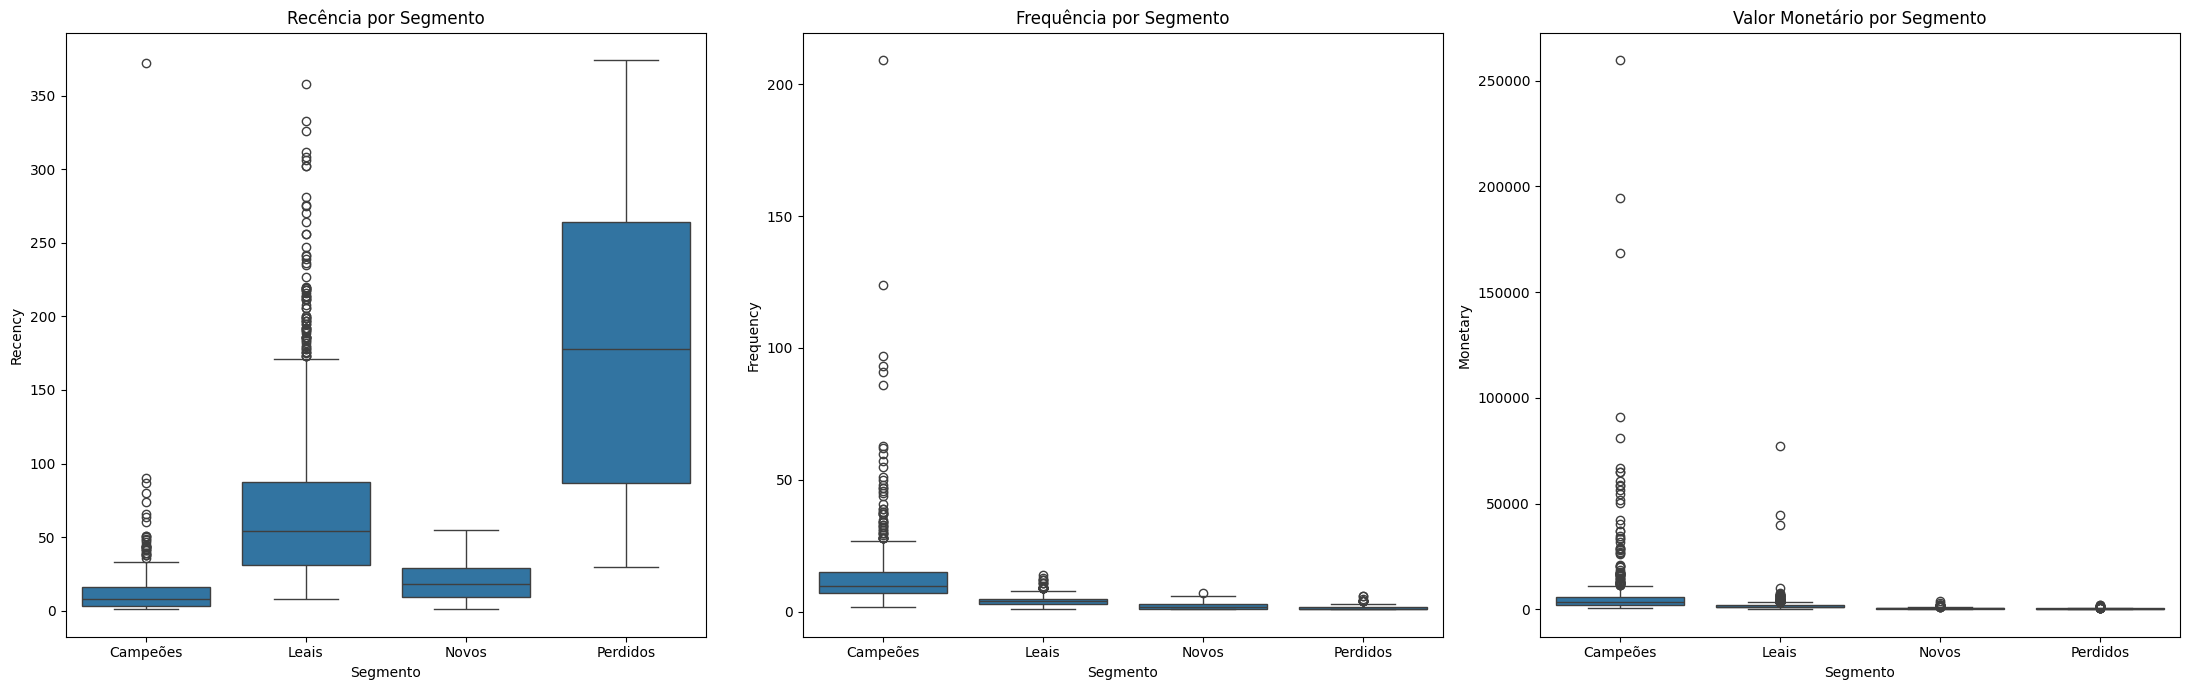

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

segment_order = ['Campeões', 'Leais', 'Novos', 'Perdidos']

sns.boxplot(data=rfm_table, x='Segmento', y='Recency', ax=axes[0], order=segment_order)
axes[0].set_title('Recência por Segmento')

sns.boxplot(data=rfm_table, x='Segmento', y='Frequency', ax=axes[1], order=segment_order)
axes[1].set_title('Frequência por Segmento')

sns.boxplot(data=rfm_table, x='Segmento', y='Monetary', ax=axes[2], order=segment_order)
axes[2].set_title('Valor Monetário por Segmento')

plt.tight_layout()
plt.show()


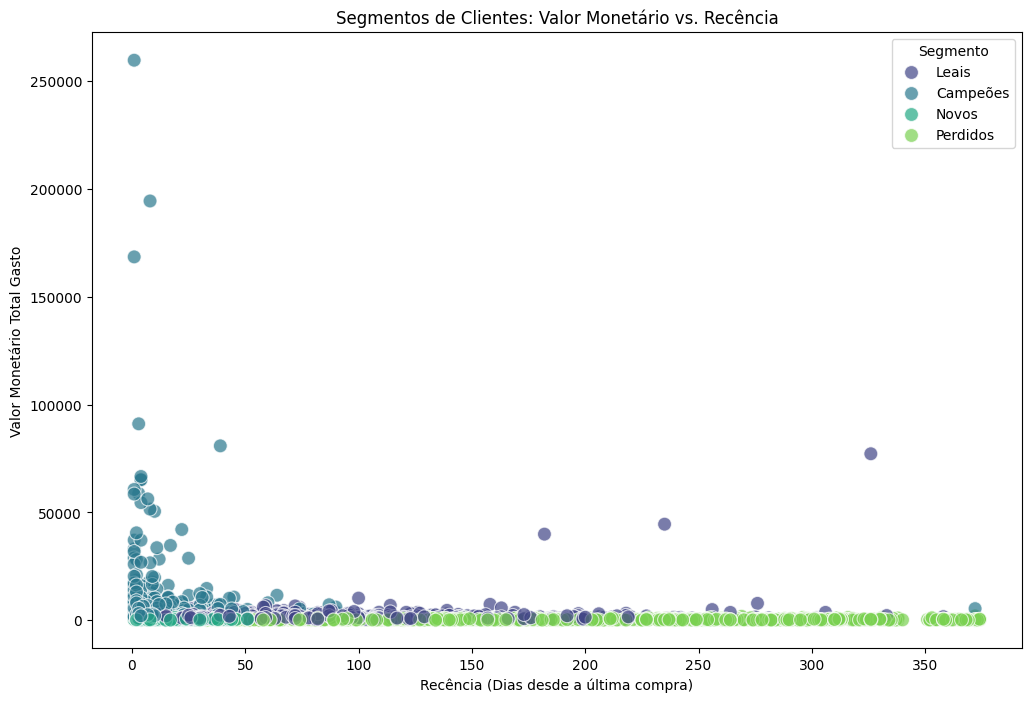

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=rfm_table,
    x='Recency',
    y='Monetary',
    hue='Segmento',
    palette='viridis',
    alpha=0.7,
    s=100
)
plt.title('Segmentos de Clientes: Valor Monetário vs. Recência')
plt.xlabel('Recência (Dias desde a última compra)')
plt.ylabel('Valor Monetário Total Gasto')
plt.legend(title='Segmento')
plt.show()

In [26]:
segment_counts = rfm_table['Segmento'].value_counts()
segment_percent = rfm_table['Segmento'].value_counts(normalize=True) * 100

summary_final = pd.DataFrame({
    'Segmento': segment_counts.index,
    'Contagem': segment_counts.values,
    'Percentual (%)': segment_percent.values
})

print("Composição da Base de Clientes:")
summary_final.sort_values(by='Percentual (%)', ascending=False)

Composição da Base de Clientes:


,Segmento,Contagem,Percentual (%)
0,Perdidos,1436,36.632653
1,Leais,1062,27.091837
2,Novos,779,19.872449
3,Campeões,643,16.403061


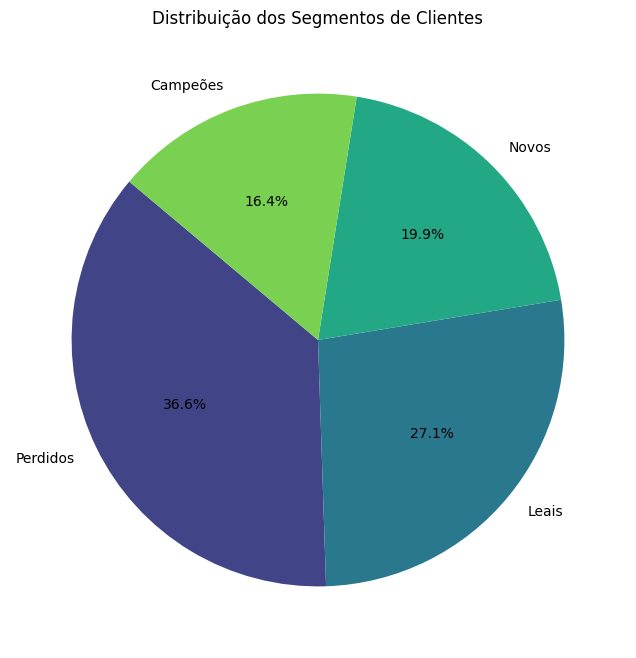

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(summary_final['Contagem'], 
        labels=summary_final['Segmento'], 
        autopct='%1.1f%%', 
        startangle=140,
        colors=sns.color_palette('viridis', n_colors=4))
plt.title('Distribuição dos Segmentos de Clientes')
plt.show()